In [93]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('./dataset/data.csv')
dataset.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [94]:
dataset = dataset.drop('shot_id', axis=1)

In [95]:
dataset.describe(include='object')

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


In [96]:
dataset = dataset.drop('team_name', axis=1)

In [97]:
dataset.describe(include='number')

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09


In [98]:
dataset = dataset.drop('team_id', axis=1)

In [99]:
X_train = dataset[dataset['shot_made_flag'].notnull()]
y_train = X_train['shot_made_flag']
X_train.shape

(25697, 22)

In [100]:
X_test = dataset[dataset['shot_made_flag'].isnull()].drop( 'shot_made_flag',axis=1)
X_test.shape

(5000, 21)

In [101]:
X_train.groupby(X_train['shot_made_flag'] == 1).describe(include='object')

action_type                          combined_shot_type         \
                     count unique        top   freq              count unique   
shot_made_flag                                                                  
False                14232     50  Jump Shot  10659              14232      6   
True                 11465     54  Jump Shot   5177              11465      6   

                                 season        ...    game_date      matchup  \
                      top   freq  count unique ...          top freq   count   
shot_made_flag                                 ...                             
False           Jump Shot  12002  14232     20 ...   2002-11-07   27   14232   
True            Jump Shot   7708  11465     20 ...   2006-01-22   22   11465   

                                      opponent                   
               unique        top freq    count unique  top freq  
shot_made_flag                                                   
False              74  LAL @ SAS  488    14232     33  SAS  923  
True               74  LAL @ SAS  365    11465     33  SAS  715  

[2 rows x 40 columns]

In [120]:
X_train.groupby(X_train['shot_made_flag'] == 1).describe(include='number') 

game_event_id                                             \
                       count        mean         std  min    25%    50%   
shot_made_flag                                                            
False                14232.0  254.353710  150.496288  2.0  117.0  258.0   
True                 11465.0  243.135717  148.655004  2.0  105.0  248.0   

                              game_id               ...  shot_distance        \
                  75%    max    count          mean ...            75%   max   
shot_made_flag                                      ...                        
False           374.0  653.0  14232.0  2.475229e+07 ...           22.0  79.0   
True            357.0  650.0  11465.0  2.472719e+07 ...           19.0  43.0   

               shot_made_flag                                     
                        count mean  std  min  25%  50%  75%  max  
shot_made_flag                                                    
False                 14232.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
True                  11465.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  

[2 rows x 96 columns]

In [121]:
X_train.groupby(X_train['shot_made_flag'] == 0).describe(include='object') 

action_type                          combined_shot_type         \
                     count unique        top   freq              count unique   
shot_made_flag                                                                  
False                11465     54  Jump Shot   5177              11465      6   
True                 14232     50  Jump Shot  10659              14232      6   

                                 season        ...  game_year        \
                      top   freq  count unique ...        top  freq   
shot_made_flag                                 ...                    
False           Jump Shot   7708  11465     20 ...       2009   924   
True            Jump Shot  12002  14232     20 ...       2012  1051   

               game_mounth                  game_day                  
                     count unique top  freq    count unique top freq  
shot_made_flag                                                        
False                11465      9  03  1896    11465     31  04  501  
True                 14232      9  03  2428    14232     31  04  622  

[2 rows x 52 columns]

In [122]:
X_train.groupby(X_train['shot_made_flag'] == 0).describe(include='number')

game_event_id                                             \
                       count        mean         std  min    25%    50%   
shot_made_flag                                                            
False                11465.0  243.135717  148.655004  2.0  105.0  248.0   
True                 14232.0  254.353710  150.496288  2.0  117.0  258.0   

                              game_id               ...  shot_distance        \
                  75%    max    count          mean ...            75%   max   
shot_made_flag                                      ...                        
False           357.0  650.0  11465.0  2.472719e+07 ...           19.0  43.0   
True            374.0  653.0  14232.0  2.475229e+07 ...           22.0  79.0   

               shot_made_flag                                     
                        count mean  std  min  25%  50%  75%  max  
shot_made_flag                                                    
False                 11465.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
True                  14232.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 96 columns]

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

#X_train.sort_values(by=X_train['action_type'].)
X_train['action_type'].groupby(X_train['shot_made_flag']).count()

X_train_success = X_train.groupby(X_train['shot_made_flag']==1)
X_train_false =  X_train.groupby(X_train['shot_made_flag']== 0) 

pandas.core.groupby.groupby.DataFrameGroupBy

/Users/y_tamura/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, *

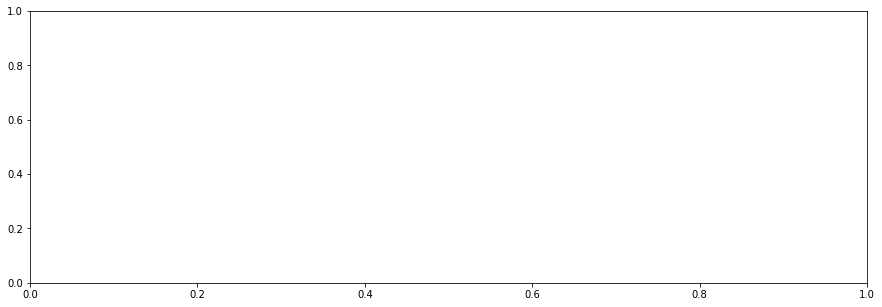

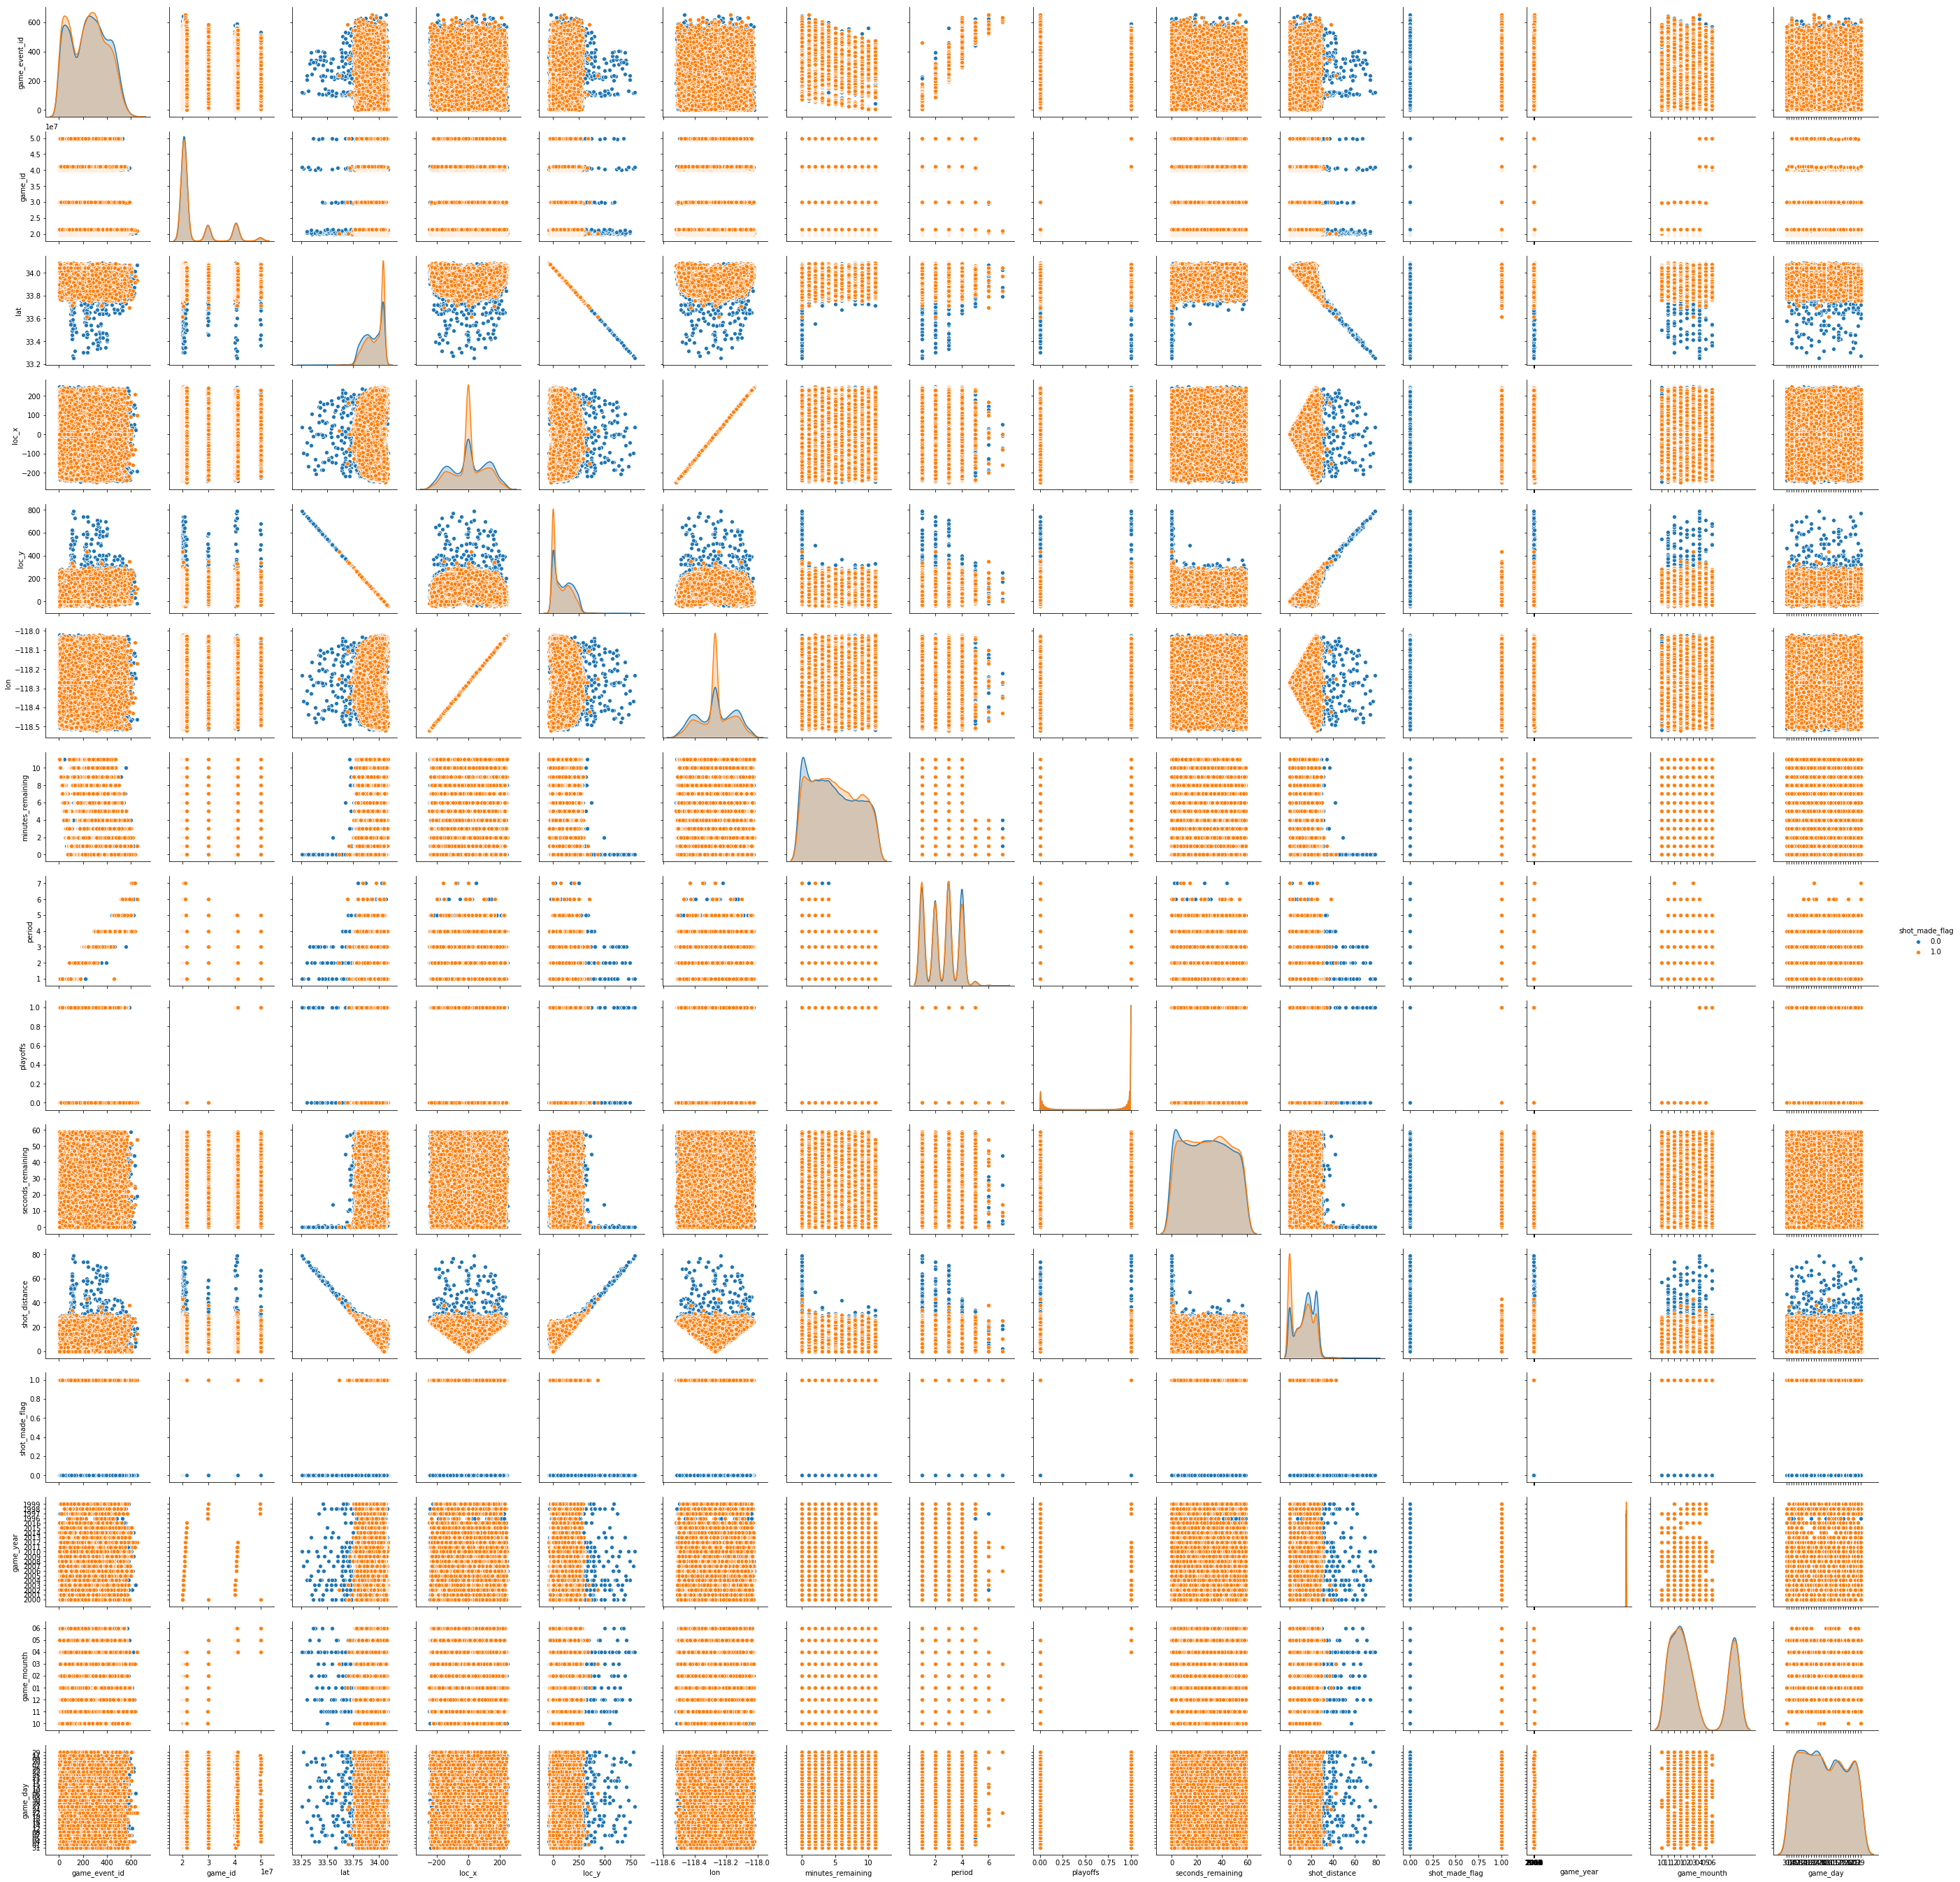

In [144]:
sns.pairplot(X_train, hue='shot_made_flag')

/Users/y_tamura/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


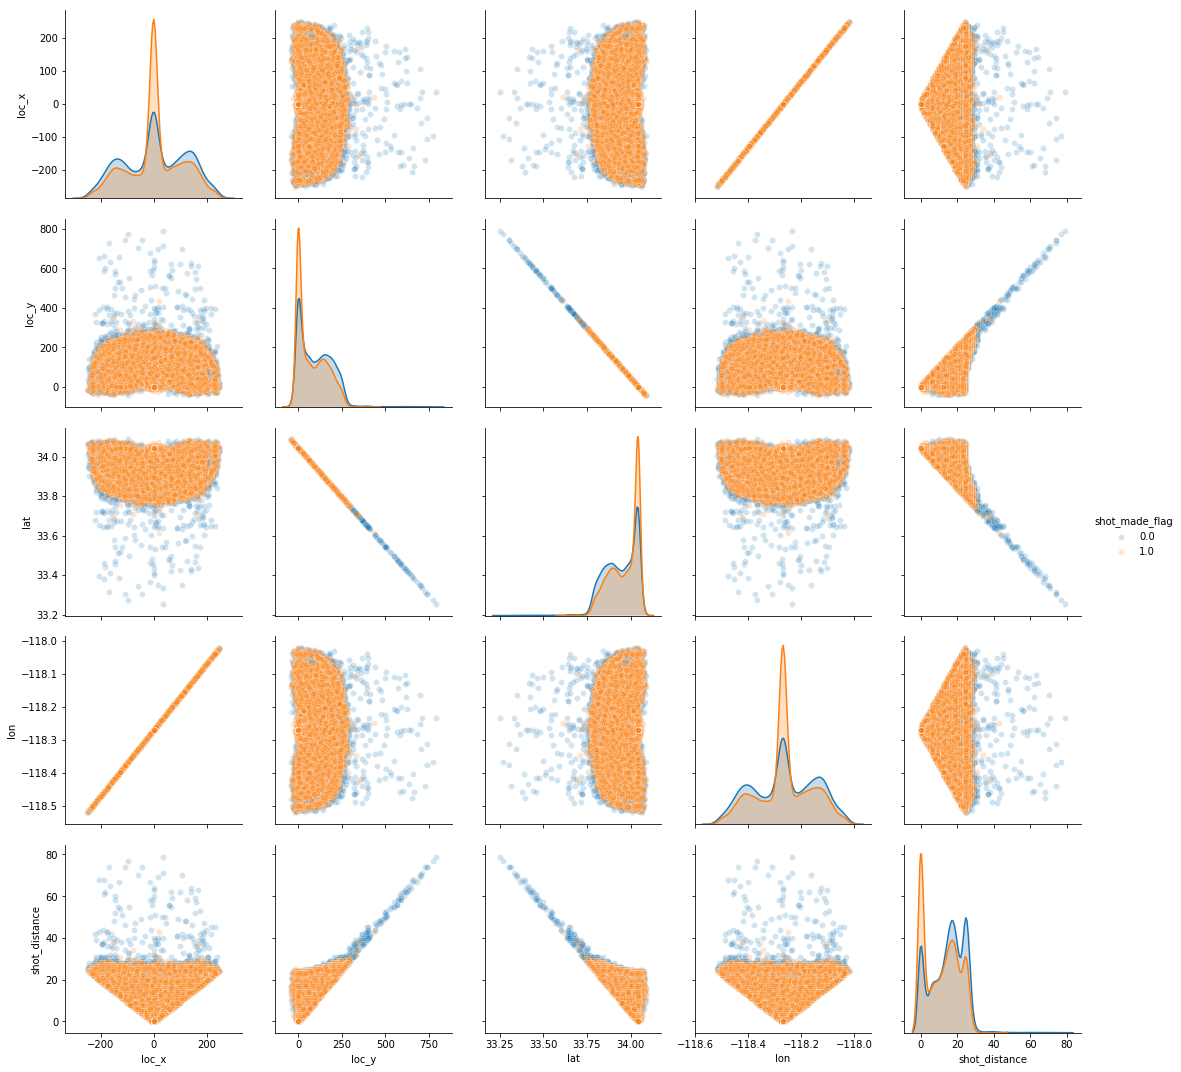

In [170]:
sns.pairplot(X_train, vars=['loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'], hue='shot_made_flag', size=3,plot_kws={'alpha': 0.2})  

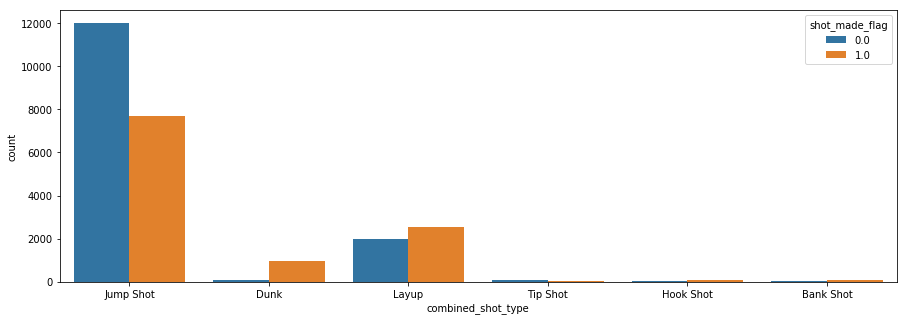

In [103]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=X_train)

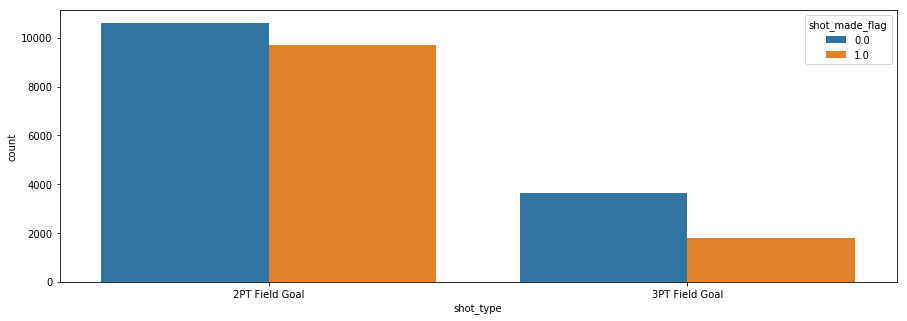

In [104]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x='shot_type', hue="shot_made_flag", data=X_train)

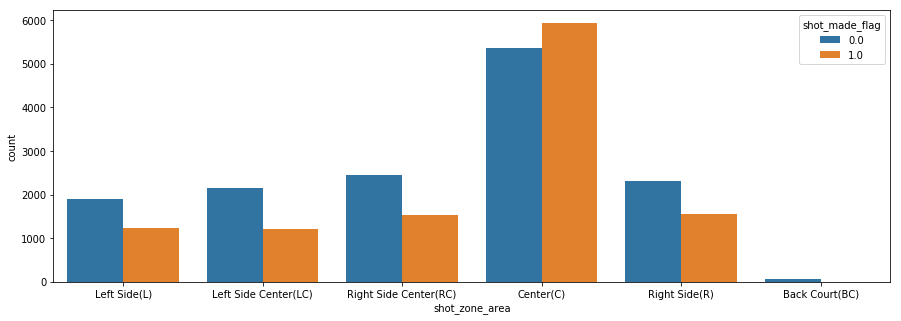

In [105]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x='shot_zone_area', hue="shot_made_flag", data=X_train)

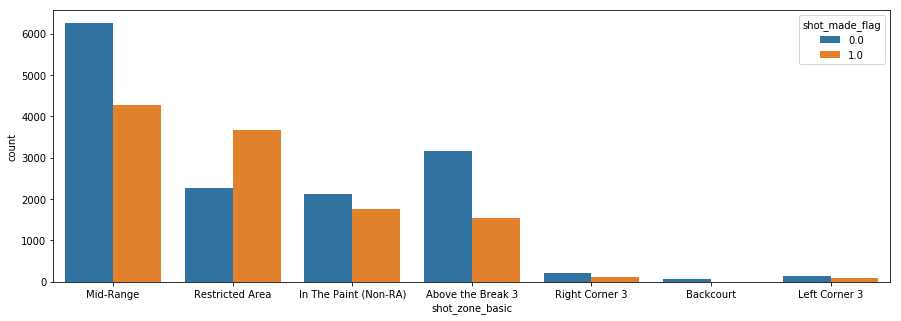

In [165]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x='shot_zone_basic', hue="shot_made_flag", data=X_train)

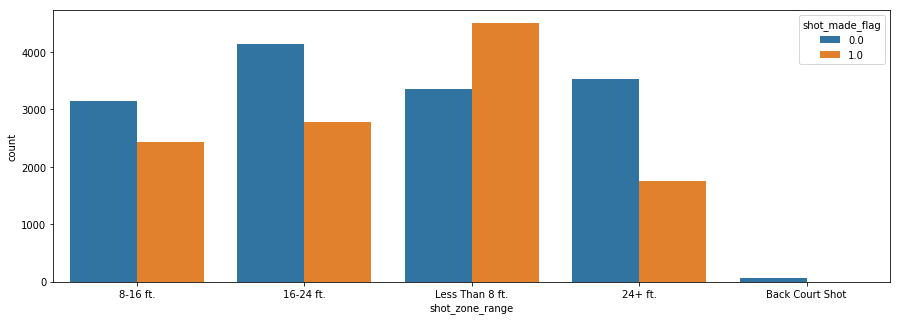

In [107]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x='shot_zone_range', hue="shot_made_flag", data=X_train)

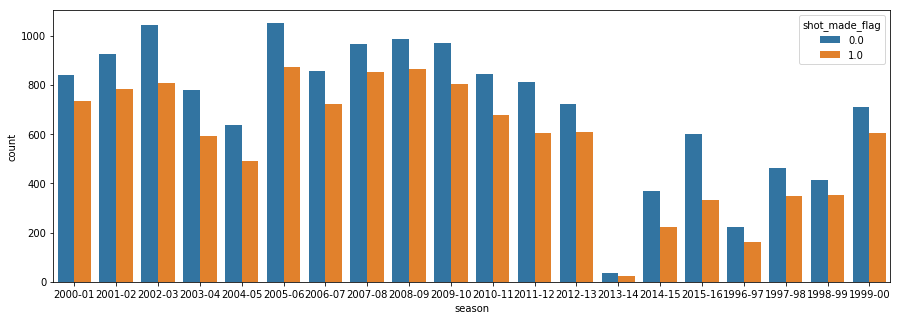

In [108]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x=X_train["season"], hue="shot_made_flag", data=X_train)

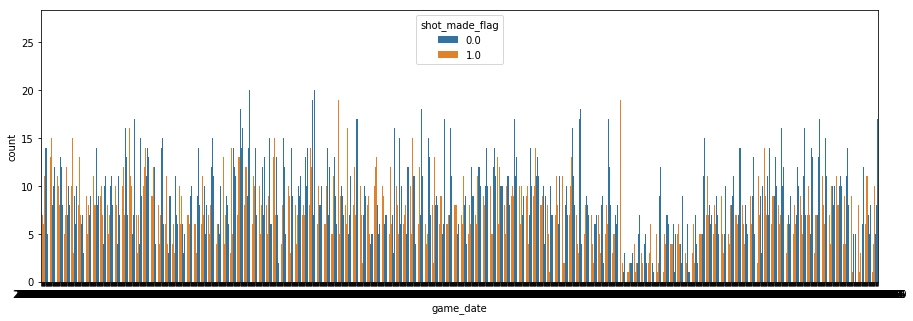

In [90]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(x='game_date', hue="shot_made_flag", data=X_train)

In [109]:
X_train['game_date'].describe()

count          25697
unique          1558
top       2016-04-13
freq              43
Name: game_date, dtype: object

In [166]:
X_train['game_date'].str.split("-", expand=True)
X_train['game_year'] = X_train['game_date'].str.split("-", expand=True)[0]
X_train['game_mounth'] = X_train['game_date'].str.split("-", expand=True)[1]
X_train['game_day'] = X_train['game_date'].str.split("-", expand=True)[2] 

/Users/y_tamura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/y_tamura/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

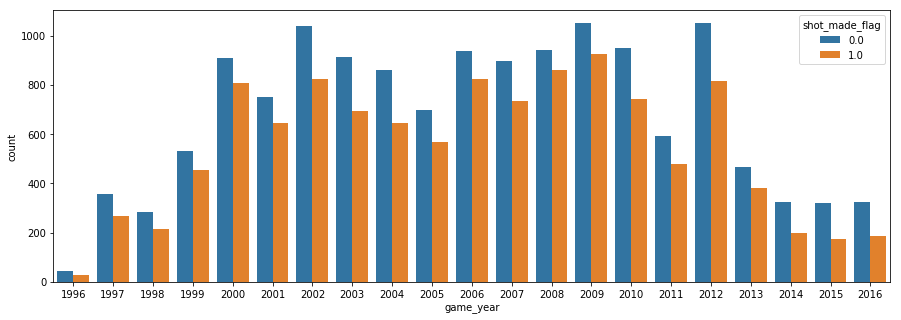

In [115]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(X_train['game_year'], hue="shot_made_flag", data=X_train)

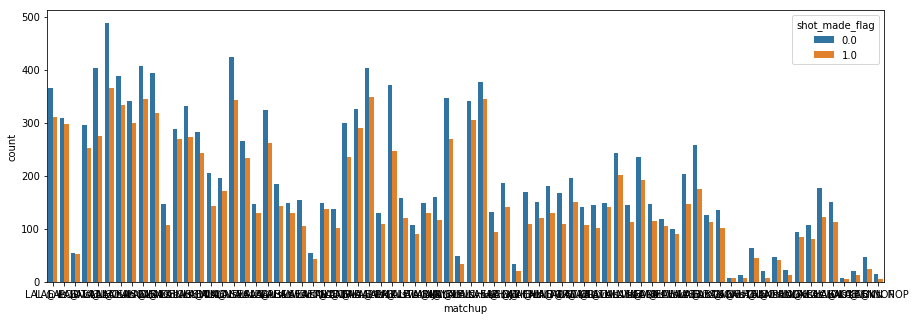

In [116]:
f, axarr = plt.subplots(figsize=(15, 5)) 
sns.countplot(X_train['matchup'], hue="shot_made_flag", data=X_train)